## - Code for Kaggle competition code: Digit recognizer -

#### Import modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys 
from myFunctions import myPrint

### - Import the data -
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. 
Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

### - Visualise some of the data -

#### First 10 entries in dataset

In [3]:
print(train_data.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

#### Plot one of the numbers

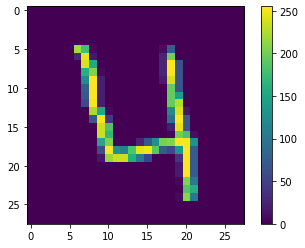

In [4]:
data_choice = 3
image_matrix = np.reshape((train_data.iloc[data_choice].drop('label', axis = 0)).tolist(),(28,28))
plt.imshow(image_matrix)
plt.colorbar()
plt.show()

#### Scale the data
Scale the pixel input [0 - 255] --> [0 - 1] for both train and test data. 
Note this takes a few minutes

In [5]:
new_train_data = train_data.copy()
new_test_data = test_data.copy()
new_train_data[new_train_data.columns[1:-1]] = new_train_data[new_train_data.columns[1:-1]]/255
new_test_data[new_test_data.columns[1:-1]] = new_test_data[new_test_data.columns[1:-1]]/255
print("Data Scaled")

Data Scaled


#### Split the data into a train (60%), validation (20%) and test (20%) set

In [6]:
train_data_length = len(new_train_data)
test_data_length = len(new_test_data)
print("Train data length = ", train_data_length, " Test data length = ", test_data_length)

Train data length =  42000  Test data length =  28000


In [7]:
cutone = int(0.6*train_data_length)
cuttwo = int(0.8*train_data_length)

In [8]:
X_train = new_train_data.iloc[:cutone].drop('label', axis = 1)
Y_train = new_train_data.iloc[:cutone]['label']
X_valid = new_train_data.iloc[cutone:cuttwo].drop('label', axis = 1)
Y_valid = new_train_data.iloc[cutone:cuttwo]['label']
X_test = new_train_data.iloc[cuttwo:].drop('label', axis = 1)
Y_test = new_train_data.iloc[cuttwo:]['label']

### - Train the model -

#### Clear the tensorflow session

In [9]:
tf.keras.backend.clear_session()

#### Choose the model to fit. Choice is between a Dense neural network or a CNN

In [10]:
model = 'CNN'

if model == 'Dense':
    print('Dense')
    ## Build a dense neural network
    ## Neural network has input layer of 28*28, hidden middle layer with 128 nodes and output layer with 10 nodes for 0:9
    model = tf.keras.Sequential([
                tf.keras.layers.Flatten(input_shape = (28*28, 1)),
                tf.keras.layers.Dense(128, activation = tf.nn.relu),
                tf.keras.layers.Dense(10, activation = tf.nn.softmax),
                ])
elif model == 'CNN':
    print('CNN')
    ### Build a CNN with 2 Convolutional layers using a 3x3 kernel to generate 32 and 64 images, respectively
    ### Also have a MaxPool layer after each Convolutional layer with a 2x2 grid and stride of 2 to half image size each time
    ### Last layer flattens all the images and feeds into a hidden dense layer with 128 neurons, before feeding to output layer
    ### with 10 nodes for 0:9
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        ])
    ## Note that for CNN data needs reshaping.
    X_train = (X_train.to_numpy()).reshape((cutone,28,28))
    X_valid = (X_valid.to_numpy()).reshape((cuttwo - cutone,28,28))
    X_test = (X_test.to_numpy()).reshape((train_data_length - cuttwo,28,28))
    new_test_data = (new_test_data.to_numpy()).reshape((test_data_length,28,28))
else:
        myPrint("No model selected")
        sys.exit()

CNN


#### Set the learning rate

In [11]:
lr = 1e-3

#### Compile the model

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
             metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

#### Set number of epochs

In [13]:
num_epochs = 5

#### Fit the model, using a validation set too.

In [14]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs = num_epochs,
                    validation_data = (X_valid,Y_valid),)

Epoch 1/5
788/788 [==============================] - 10s 12ms/step - loss: 0.1954 - accuracy: 0.9392 - val_loss: 0.0694 - val_accuracy: 0.9776
Epoch 2/5
788/788 [==============================] - 10s 12ms/step - loss: 0.0558 - accuracy: 0.9828 - val_loss: 0.0599 - val_accuracy: 0.9805
Epoch 3/5
788/788 [==============================] - 9s 12ms/step - loss: 0.0365 - accuracy: 0.9884 - val_loss: 0.0544 - val_accuracy: 0.9839
Epoch 4/5
788/788 [==============================] - 9s 12ms/step - loss: 0.0259 - accuracy: 0.9919 - val_loss: 0.0399 - val_accuracy: 0.9868
Epoch 5/5
788/788 [==============================] - 9s 11ms/step - loss: 0.0195 - accuracy: 0.9934 - val_loss: 0.0591 - val_accuracy: 0.9818


#### Look at cross validation
Probably not needed for small number of epochs?

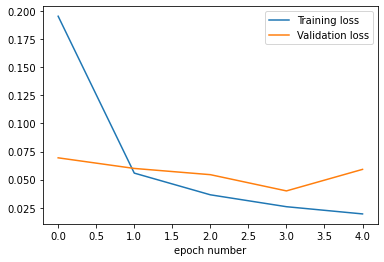

In [15]:
epoch_range = range(num_epochs)
val_loss = history.history['val_loss']
plt.plot(epoch_range, history.history['loss'], label = 'Training loss')
plt.plot(epoch_range, history.history['val_loss'], label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.xlabel('epoch number')
plt.show()

#### Look at single prediction

In [16]:
print((Y_test.iloc[3:4]).iloc[0])
predict = np.argmax(model.predict(X_test), axis = 1);
print(predict)

2
[0 7 7 ... 7 6 9]


#### Evaluate the model on training set and then test set

In [17]:
print(model.evaluate(X_train, Y_train))
print(model.evaluate(X_test, Y_test))

788/788 [==============================] - 3s 4ms/step - loss: 0.0250 - accuracy: 0.9916: 1s - l
[0.025030456483364105, 0.9916269779205322]
263/263 [==============================] - 1s 5ms/step - loss: 0.0571 - accuracy: 0.9818
[0.05707137659192085, 0.9817857146263123]


### - Create predictions for the test data and create submission file -

In [18]:
new_predict = np.argmax(model.predict(new_test_data), axis = 1);
np.savetxt('submission_NE.csv', np.c_[range(1,len(new_test_data)+1), new_predict], delimiter = ',', header = 'ImageID,Label', comments = '', fmt = '%d')

### - Save the trained model for use in other file -

In [19]:
export_path_keras = "saved_model.h5"
model.save(export_path_keras)